# Evaluation of the health of forests in Bhutan
#### Analysis with satellite images of Sentinel -2
#### Presentation of the NDVI Index for a quick assessment of the health of forests in Bhutan.

In [1]:
# Import necessary packages
import os
import json
import up42
import folium
import pyproj 
import matplotlib
import numpy as np
import pandas as pd  
import rasterio as rio
import geopandas as gpd   
from rasterio import plot
#from matplotlib import cm
import matplotlib.cm as cm
from folium import plugins
from matplotlib import pyplot
from functools import partial
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from rasterio.plot import reshape_as_raster, show                                                               
from rasterio import features                                                 
from rasterio.warp import calculate_default_transform, reproject, Resampling  
from shapely.geometry import LineString, MultiPolygon, Point, Polygon, box    
from shapely.geometry import shape as shapely_shp                             
from shapely.ops import cascaded_union, transform                             

In [2]:
# Allows for ignoring errors + division by zero
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
# Set directory to download the results
quicklook_dir = "./results/catalog/sentinel2/"
sentinel_dir = "./results/sentinel_2/"

In [4]:
# Authentification
# https://console.up42.com/ --> Developers
up42.authenticate(project_id="a7c22b41-77e4-4858-a90f-d22caa7788c2", 
                  project_api_key="XFhdgIzI.PqLIPJQXqucVbEf3wtNGlZ8lw2DiH7aBZWF")

2021-06-30 17:07:09,067 - Authentication with UP42 successful!


In [5]:
# Checking the blocks
#up42.get_blocks()
#up42.get_block_details()

In [6]:
# Get the current working directory
os.getcwd()

'/home/diego/GITHUP_REPO/Challenge_up42'

### Catalog Search
#### Search cloudfree Sentinel-2 images for the AOI and visualise the quicklooks.

In [7]:
# Geojason of the Bhutan forest
# obtained from https://mapcruzin.com/bhutan-shapefiles/bhutan_natural.zip
Bhutan_forest = json.load(open('bhutan_forest.geojson'))

# Area of interest inside of the Bhutan forest
aoi = up42.read_vector_file('AOI_Bhutan_Forest.geojson', as_dataframe=False)

In [8]:
# Search the area via catalog search
# Warning!! This function is deprecated

#catalog = up42.initialize_catalog()

#search_parameters = catalog.construct_parameters(geometry=aoi, 
#                                                 start_date="2021-01-01",
#                                                 end_date="2021-05-31",
#                                                 sensors=["sentinel2"],
#                                                 max_cloudcover=10,
#                                                 sortby='cloudCoverage')

#search_results = catalog.search(search_parameters=search_parameters)
#display(search_results.head())

#catalog.download_quicklooks(image_ids=search_results.id.to_list(), 
#                            sensor="sentinel2", 
#                            output_directory=quicklook_dir)

#catalog.plot_quicklooks(figsize=(15,5), titles=search_results.sceneId.to_list())

# Select least cloud scene for further workflow
#aoi["sceneId"] = search_results.sceneId.to_list()[0]

### NDVI project using Sentinel-2 for a Bhutan forest sample
#### Find the most current image available as a sample

In [9]:
# Initialize the project
# https://console.up42.com/ --> Projects
project = up42.initialize_project()
    
# Init workflow --> forests_bhutan
workflow = project.create_workflow(name="forests_bhutan_sentinel_2", use_existing=True)

2021-06-30 17:07:10,158 - Initialized Project(name: Up42_challenge, project_id: a7c22b41-77e4-4858-a90f-d22caa7788c2, description: Evaluate the health of forests in Bhutan - Bruno Brazil Associates, createdAt: 2021-06-29T13:45:22.401521Z)
2021-06-30 17:07:10,161 - Getting existing workflows in project ...
2021-06-30 17:07:10,581 - Got 3 workflows for project a7c22b41-77e4-4858-a90f-d22caa7788c2.
100%|██████████| 3/3 [00:01<00:00,  2.50it/s]
2021-06-30 17:07:11,787 - Using existing workflow: forests_bhutan_sentinel_2 - 5196073f-5aea-43d6-9d91-d55cbf124172


In [10]:
# Workflow with our desired data block
input_tasks = ["Sentinel-2 L2A Analytic (GeoTIFF)"]

# Update workflow object with our desired data block as input_task(s)
workflow.add_workflow_tasks(input_tasks)
workflow

2021-06-30 17:07:15,642 - Added tasks to workflow: [{'name': 'esa-s2-l2a-gtiff-analytic:1', 'parentName': None, 'blockId': 'e13d8e92-2763-4640-80d6-1501b2729707'}]


Workflow(name: forests_bhutan_sentinel_2, workflow_id: 5196073f-5aea-43d6-9d91-d55cbf124172, description: , createdAt: 2021-06-30T13:17:22.499736Z, project_id: a7c22b41-77e4-4858-a90f-d22caa7788c2, workflow_tasks: {'esa-s2-l2a-gtiff-analytic:1': '1.3.1'}

In [11]:
# Construct input parameters
input_parameters = workflow.construct_parameters(geometry=aoi, 
                                                 geometry_operation='contains', 
                                                 start_date="2021-01-01",
                                                 end_date="2021-06-29",
                                                 limit=10)

# Update input parameters
input_parameters["esa-s2-l2a-gtiff-analytic:1"].update({"max_cloud_cover":10})
input_parameters

{'esa-s2-l2a-gtiff-analytic:1': {'time': '2021-01-01T00:00:00Z/2021-06-29T23:59:59Z',
  'limit': 10,
  'max_cloud_cover': 10,
  'contains': {'type': 'Polygon',
   'coordinates': (((90.23863465716029, 27.105424599204458),
     (90.64090865457698, 27.105424599204458),
     (90.64090865457698, 27.43797110373558),
     (90.23863465716029, 27.43797110373558),
     (90.23863465716029, 27.105424599204458)),)}}}

In [12]:
# Price estimation
workflow.estimate_job(input_parameters)

2021-06-30 17:07:25,119 - Estimated: 1-1 Credits, Duration: 0-0 min.


{'esa-s2-l2a-gtiff-analytic:1': {'blockConsumption': {'resources': {'unit': 'SQUARE_KM',
    'min': 0,
    'max': 0},
   'credit': {'min': 0, 'max': 0}},
  'machineConsumption': {'duration': {'min': 0, 'max': 0},
   'credit': {'min': 1, 'max': 1}}}}

In [13]:
# Run test job to query data availability and check the configuration.
test_job = workflow.test_job(input_parameters, track_status=True)

2021-06-30 17:07:25,131 - +++++++++++++++++++++++++++++++++
2021-06-30 17:07:25,133 - Running this job as Test Query...
2021-06-30 17:07:25,134 - +++++++++++++++++++++++++++++++++
2021-06-30 17:07:25,135 - Selected input_parameters: {'esa-s2-l2a-gtiff-analytic:1': {'time': '2021-01-01T00:00:00Z/2021-06-29T23:59:59Z', 'limit': 10, 'max_cloud_cover': 10, 'contains': {'type': 'Polygon', 'coordinates': (((90.23863465716029, 27.105424599204458), (90.64090865457698, 27.105424599204458), (90.64090865457698, 27.43797110373558), (90.23863465716029, 27.43797110373558), (90.23863465716029, 27.105424599204458)),)}}, 'config': {'mode': 'DRY_RUN'}}
2021-06-30 17:07:26,238 - Created and running new job: b8c25412-9a97-4c78-8276-42538c6913e5.
2021-06-30 17:07:26,657 - Tracking job status continuously, reporting every 30 seconds...
2021-06-30 17:07:43,422 - Job finished successfully! - b8c25412-9a97-4c78-8276-42538c6913e5


In [14]:
# Run the actual job
job = workflow.run_job(input_parameters=input_parameters, track_status=True)

2021-06-30 17:07:48,433 - Selected input_parameters: {'esa-s2-l2a-gtiff-analytic:1': {'time': '2021-01-01T00:00:00Z/2021-06-29T23:59:59Z', 'limit': 10, 'max_cloud_cover': 10, 'contains': {'type': 'Polygon', 'coordinates': (((90.23863465716029, 27.105424599204458), (90.64090865457698, 27.105424599204458), (90.64090865457698, 27.43797110373558), (90.23863465716029, 27.43797110373558), (90.23863465716029, 27.105424599204458)),)}}}
2021-06-30 17:07:52,759 - Created and running new job: 496a0a56-b319-4402-b8f0-58f1dca5eb26.
2021-06-30 17:07:53,205 - Tracking job status continuously, reporting every 30 seconds...
2021-06-30 17:08:26,292 - Job is RUNNING! - 496a0a56-b319-4402-b8f0-58f1dca5eb26
2021-06-30 17:08:59,114 - Job is RUNNING! - 496a0a56-b319-4402-b8f0-58f1dca5eb26
2021-06-30 17:09:31,993 - Job is RUNNING! - 496a0a56-b319-4402-b8f0-58f1dca5eb26
2021-06-30 17:10:05,216 - Job is RUNNING! - 496a0a56-b319-4402-b8f0-58f1dca5eb26
2021-06-30 17:10:38,229 - Job is RUNNING! - 496a0a56-b319-440

In [15]:
# Download results and quicklooks to "results/sentinel/"" folder in current directory
job.download_results(sentinel_dir)
job.download_quicklooks(sentinel_dir)

2021-06-30 17:25:08,562 - Downloading results of job 496a0a56-b319-4402-b8f0-58f1dca5eb26
2021-06-30 17:25:08,568 - Download directory: results/sentinel_2
913168it [00:01, 488218.16it/s]
2021-06-30 17:31:24,519 - Download successful of 105 files to output_directory 'results/sentinel_2': ['S2B_46RBR_20210516_1_L2A_B06.tif', 'S2B_46RBR_20210516_1_L2A_vrt.vrt', 'S2B_46RBR_20210516_1_L2A_B12.tif', 'S2B_46RBR_20210516_1_L2A_B04.tif', 'S2B_46RBR_20210516_1_L2A_B09.tif', 'S2B_46RBR_20210516_1_L2A_B07.tif', 'S2B_46RBR_20210516_1_L2A_B02.tif', 'S2B_46RBR_20210516_1_L2A_B8A.tif', 'S2B_46RBR_20210516_1_L2A_B11.tif', 'S2B_46RBR_20210516_1_L2A_B05.tif', 'S2B_46RBR_20210516_1_L2A_B01.tif', 'S2B_46RBR_20210516_1_L2A_B08.tif', 'S2B_46RBR_20210516_1_L2A_B03.tif', 'S2B_46RBR_20210625_0_L2A_B02.tif', 'S2B_46RBR_20210625_0_L2A_B03.tif', 'S2B_46RBR_20210625_0_L2A_B08.tif', 'S2B_46RBR_20210625_0_L2A_B04.tif', 'S2B_46RBR_20210625_0_L2A_B06.tif', 'S2B_46RBR_20210625_0_L2A_B12.tif', 'S2B_46RBR_20210625_0_L2A_B

['results/sentinel_2/quicklook_S2A_46RBR_20210104_0_L2A.jpg',
 'results/sentinel_2/quicklook_S2A_46RBR_20210424_0_L2A.jpg',
 'results/sentinel_2/quicklook_S2A_46RBR_20210504_0_L2A.jpg',
 'results/sentinel_2/quicklook_S2A_46RBR_20210514_0_L2A.jpg',
 'results/sentinel_2/quicklook_S2B_46RBR_20210106_0_L2A.jpg',
 'results/sentinel_2/quicklook_S2B_46RBR_20210516_1_L2A.jpg',
 'results/sentinel_2/quicklook_S2B_46RBR_20210519_0_L2A.jpg',
 'results/sentinel_2/quicklook_S2B_46RBR_20210625_0_L2A.jpg']

In [16]:
# Print the Job Results
job.results

['results/sentinel_2/S2B_46RBR_20210516_1_L2A/S2B_46RBR_20210516_1_L2A_B06.tif',
 'results/sentinel_2/S2B_46RBR_20210516_1_L2A/S2B_46RBR_20210516_1_L2A_vrt.vrt',
 'results/sentinel_2/S2B_46RBR_20210516_1_L2A/S2B_46RBR_20210516_1_L2A_B12.tif',
 'results/sentinel_2/S2B_46RBR_20210516_1_L2A/S2B_46RBR_20210516_1_L2A_B04.tif',
 'results/sentinel_2/S2B_46RBR_20210516_1_L2A/S2B_46RBR_20210516_1_L2A_B09.tif',
 'results/sentinel_2/S2B_46RBR_20210516_1_L2A/S2B_46RBR_20210516_1_L2A_B07.tif',
 'results/sentinel_2/S2B_46RBR_20210516_1_L2A/S2B_46RBR_20210516_1_L2A_B02.tif',
 'results/sentinel_2/S2B_46RBR_20210516_1_L2A/S2B_46RBR_20210516_1_L2A_B8A.tif',
 'results/sentinel_2/S2B_46RBR_20210516_1_L2A/S2B_46RBR_20210516_1_L2A_B11.tif',
 'results/sentinel_2/S2B_46RBR_20210516_1_L2A/S2B_46RBR_20210516_1_L2A_B05.tif',
 'results/sentinel_2/S2B_46RBR_20210516_1_L2A/S2B_46RBR_20210516_1_L2A_B01.tif',
 'results/sentinel_2/S2B_46RBR_20210516_1_L2A/S2B_46RBR_20210516_1_L2A_B08.tif',
 'results/sentinel_2/S2B_46R

In [17]:
# Similarly store path for quicklook
ql_path = job.quicklooks[4]
ql_path

'results/sentinel_2/quicklook_S2B_46RBR_20210106_0_L2A.jpg'

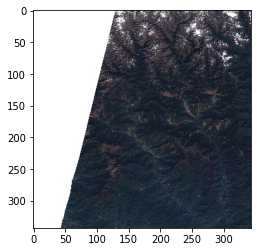

In [18]:
# Plot of quicklook: the latest and cloudless image
img = mpimg.imread(ql_path)
imgplot = plt.imshow(img)
plt.show()

In [19]:
# From the quick look after the download, we select the latest and cloudless image
# which is: S2B_46RBR_20210106_0_L2A
data_to_use='./results/sentinel_2/S2B_46RBR_20210106_0_L2A/'

In [20]:
# Store results and quicklook paths to separate variables
raster_path = [i for i in os.listdir(data_to_use) if i.endswith('.tif')]
metadata_path = [i for i in job.results if i.endswith('.json')][0]

In [21]:
# Sort the Band to make the selection easier
raster_path.sort()
raster_path

['S2B_46RBR_20210106_0_L2A_B01.tif',
 'S2B_46RBR_20210106_0_L2A_B02.tif',
 'S2B_46RBR_20210106_0_L2A_B03.tif',
 'S2B_46RBR_20210106_0_L2A_B04.tif',
 'S2B_46RBR_20210106_0_L2A_B05.tif',
 'S2B_46RBR_20210106_0_L2A_B06.tif',
 'S2B_46RBR_20210106_0_L2A_B07.tif',
 'S2B_46RBR_20210106_0_L2A_B08.tif',
 'S2B_46RBR_20210106_0_L2A_B09.tif',
 'S2B_46RBR_20210106_0_L2A_B11.tif',
 'S2B_46RBR_20210106_0_L2A_B12.tif',
 'S2B_46RBR_20210106_0_L2A_B8A.tif']

In [22]:
# Complete path of images Red and Nir
path4 = data_to_use + raster_path[3]
path8 = data_to_use + raster_path[7]
path4, path8

('./results/sentinel_2/S2B_46RBR_20210106_0_L2A/S2B_46RBR_20210106_0_L2A_B04.tif',
 './results/sentinel_2/S2B_46RBR_20210106_0_L2A/S2B_46RBR_20210106_0_L2A_B08.tif')

In [23]:
# Import bands as separate raster
band4 = rio.open(path4) #red
band8 = rio.open(path8) #nir

In [24]:
# Number of raster rows, columns
band4.height, band4.width

# Type of raster byte
band4.dtypes[0]

# Raster sytem of reference
band4.crs

# Raster transform parameters
band4.transform

# Raster values as matrix array
band4.read(1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [25]:
# Generate nir and red objects as arrays in float64 format
red = band4.read(1).astype('float64')
nir = band8.read(1).astype('float64')

# NDVI calculation, empty cells or nodata cells are reported as 0
ndvi=np.where(
    (nir+red)==0., 
    0, 
    (nir-red)/(nir+red))
ndvi[:5,:5]

# Export ndvi image
ndviImage = rio.open('./results/sentinel_2/ndviImage.tiff','w',driver='Gtiff',
                     width=band4.width, 
                     height = band4.height, 
                     count=1, crs=band4.crs, 
                     transform=band4.transform, 
                     dtype='float64')

ndviImage.write(ndvi,1)
ndviImage.close()

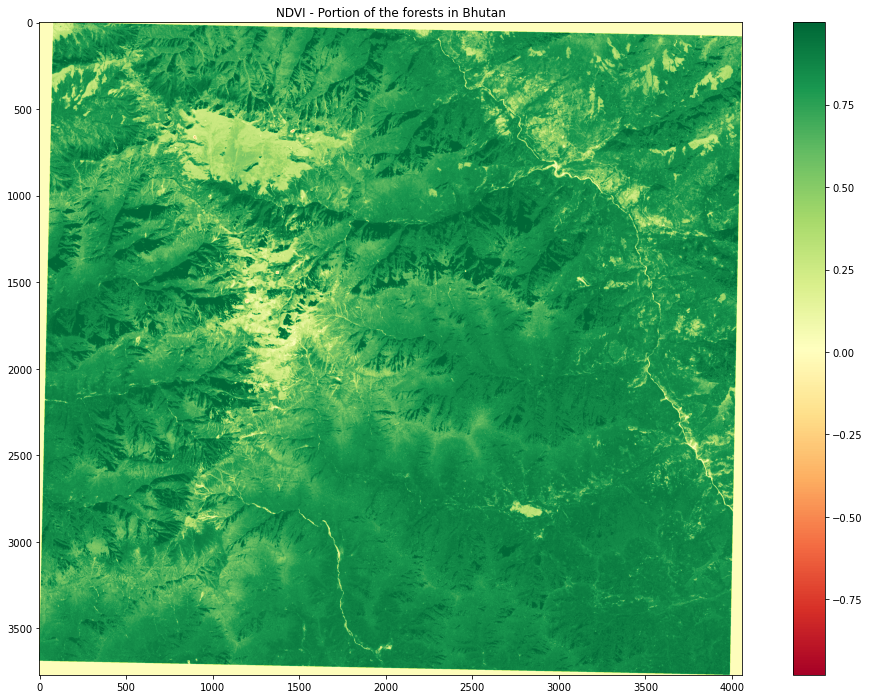

In [26]:
# Plot ndvi
ndvi = rio.open('./results/sentinel_2/ndviImage.tiff')
fig = plt.figure(figsize=(18,12))
plt.imshow(ndvi.read(1), cmap='RdYlGn')
plt.title('NDVI - Portion of the forests in Bhutan', loc='center')
plt.colorbar()
plt.show()

In [27]:
# Use rasterio to import the reprojected data as img
with rio.open('./results/sentinel_2/ndviImage.tiff') as src:
    boundary = src.bounds
    Bhutan_ndvi = src.read()
    nodata = src.nodata

#Bhutan_ndvi

In [28]:
# Selection of RdYlGn colors for NDVI image
cm = matplotlib.cm.get_cmap('RdYlGn')
colored_data = cm(Bhutan_ndvi)

#colored_data[0]

In [29]:
# Create a map using Stamen Terrain, centered on study area with set zoom level
Bhutan = folium.Map(location=[27.25, 90.4],
                    tiles='Stamen Terrain', zoom_start = 8)

# Add effected buildings
folium.GeoJson(Bhutan_forest, name = 'bhutan_forest.geojson').add_to(Bhutan)

# Overlay raster called img using add_child() function (opacity and bounding box set)
folium.raster_layers.ImageOverlay(image=colored_data[0],
                                  name='Sample Map NDVI - Bhutan forests',
                                  opacity=.7,
                                  bounds =[[27.105424599204458, 90.23863465716029], 
                                           [27.43797110373558, 90.64090865457698]]).add_to(Bhutan);

folium.LayerControl().add_to(Bhutan)

# Display map & save map as Cloud Optimized GeoTIFF
Bhutan
Bhutan.save("Bhutan_NDVI.html")